# The finite Gaussian Process Distribution of Relaxation Times (fGP-DRT)

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import finite_GP_DRT
from scipy.optimize import minimize
import importlib
importlib.reload(finite_GP_DRT)
%matplotlib inline

## 1) The 2 $\times$ ZARC model

The impedance and corresponding DRT of a double ZARC are given by
$$
Z_{\rm exact}(f) = R_\infty + \displaystyle \frac{R_{\rm ct, 1}}{\displaystyle 1+ \left(i 2\pi f \tau_1\right)^{\phi_1}} + \displaystyle \frac{R_{\rm ct, 2}}{\displaystyle 1+ \left(i 2\pi f \tau_2\right)^{\phi_2}}
$$

$$
\gamma(\log \tau) =  \displaystyle \frac{\displaystyle R_{\rm ct,1}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi_1)\pi\right)}{\displaystyle \cosh(\phi_1 \log(\tau/\tau_1))-\cos(\pi(1-\phi_1))} +\displaystyle \frac{\displaystyle R_{\rm ct,2}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi_2)\pi\right)}{\displaystyle \cosh(\phi_2 \log(\tau/\tau_2))-\cos(\pi(1-\phi_2))}
$$

### 1.1) Ranges of log frequencies and log timescales

In [79]:
# define the range of log frequencies
log_freq_min = -4.
log_freq_max = 4.

# define the range of log timescales 
log_tau_min = -4 
log_tau_max = 4  

# number of collocation points in log(freq) and log(tau)
N_freqs = 10*int(log_freq_max-log_freq_min)+1
N_taus = 10*int(log_tau_max-log_tau_min)+1

# freq and tau vectors
freq_vec = np.logspace(log_freq_min, log_freq_max, num = N_freqs, endpoint=True)
tau_vec = np.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True)
log_tau_vec = np.log(tau_vec)

### 1.2) Exact ZARC model

In [80]:
R_inf = 10

# define variables for exact
R_ct_1 = 50
phi_1 = 0.8
tau_1 = 0.1

# define variables for exact
R_ct_2 = 50
phi_2 = 0.8
tau_2 = 1E1

# Z
Z_exact_1 = R_ct_1/(1.+(1j*2.*pi*freq_vec*tau_1)**phi_1)
Z_exact_2 = R_ct_2/(1.+(1j*2.*pi*freq_vec*tau_2)**phi_2)
Z_exact = R_inf + Z_exact_1 + Z_exact_2

# gamma
gamma_fct_1 = (R_ct_1)/(2.*pi)*sin((1.-phi_1)*pi)/(np.cosh(phi_1*np.log(tau_vec/tau_1))-cos((1.-phi_1)*pi))
gamma_fct_2 = (R_ct_2)/(2.*pi)*sin((1.-phi_2)*pi)/(np.cosh(phi_2*np.log(tau_vec/tau_2))-cos((1.-phi_2)*pi))
gamma_fct = gamma_fct_1 + gamma_fct_2


### 1.3) Artificial experiments
$Z = Ax + \varepsilon$      where     $\boldsymbol{\varepsilon} \sim \mathcal{N}(\mathbf{0},\sigma_{n}^{2} \mathbf{I})$  

In [81]:
# we will add white noise to the impedance computed analytically
rng = np.random.seed(12129)
sigma_n_exp = 0.5
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

We define $\mathbf Z_{\rm re-im} = \begin{pmatrix}
 \mathbf{Z}_{\rm re} \\
 \mathbf{Z}_{\rm im} 
\end{pmatrix}$

In [82]:
Z_exp_re_im = np.zeros(2*N_freqs)
Z_exp_re_im[:N_freqs] = Z_exp.real
Z_exp_re_im[N_freqs:] = Z_exp.imag

## 2) Nyquist plot of the artificial impedance

### Figure 8(a) in fG-DRT paper

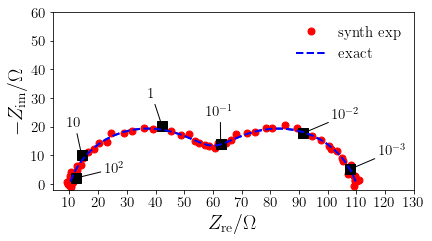

In [83]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Nyquist plot of the impedance
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=2, color='blue')
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[10:70:10]), -np.imag(Z_exp[10:70:10]), 's', markersize=10, color="black")
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=2, color='blue', label='exact')

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 140, 10))
plt.yticks(range(0, 70, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.annotate(r'$10^{-3}$', xy=(np.real(Z_exp[10]), -np.imag(Z_exp[10])), 
             xytext=(np.real(Z_exp[10])+10, 5-np.imag(Z_exp[10])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])+10, 5-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-5, 10-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40])-5, 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-5, 10-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^2$', xy=(np.real(Z_exp[60]), -np.imag(Z_exp[60])), 
             xytext=(np.real(Z_exp[60])+10, 2-np.imag(Z_exp[60])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

fig = plt.gcf()

fig.set_size_inches(6.472, 4)##

plt.show()

### The matrices $\mathbf{A}_{\rm re}$, $\mathbf{A}_{\rm im}$ and $A$

In [84]:
# compute A_re and A_im
A_re = finite_GP_DRT.compute_A_re(freq_vec, tau_vec)
A_im = finite_GP_DRT.compute_A_im(freq_vec, tau_vec)

# matrix A
A = np.zeros((2*N_freqs, N_taus+1))
# real part
A[:N_freqs, 0] = 1.0 
A[:N_freqs, 1:] = A_re
# imaginary part
A[N_freqs:, 1:] = A_im

### 2.2) Selection of the optimal hyperparameters of the unconstrained GP-DRT model by minimizing the negative marginal log-likelihood (NMLL)

The values of the hyperparameter vector $\boldsymbol{\theta}$ were obtained by maximizing the experimental evidence, i.e., by maximizing the probability $p(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf{x}, \boldsymbol \theta)$   of the experiment under no constraint on $\mathbf{x}$.

$$
\log\left(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf x, \boldsymbol\theta\right) = - \frac{1}{2} \mathbf{Z}_{\rm exp}^\top \mathbf (A\boldsymbol{\Gamma}A^{\top} + \sigma_{n}^{2}\mathbf{I})^{-1}\mathbf{Z}_{\rm exp} -\frac{1}{2} \log(|A\boldsymbol{\Gamma}A^{\top} + \sigma_{n}^{2}\mathbf{I}|) - \frac{N+1}{2} \log \left( 2\pi\right)
$$
In the actual implementation
$$
L(\boldsymbol{\theta}) = -\log\left(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf x, \boldsymbol\theta\right)-\frac{N+1}{2} \log \left( 2\pi\right)
$$

The above minimization problem is solved using the `optimize` function from `scipy`.

#### 2.2.1) Initialization of the parameters for the NMLL minimization

In [85]:
sigma_n = sigma_n_exp
sigma_R = 11.0      
sigma_f = 9.0     
ell = 1.1           

theta_0 = np.array([sigma_n, sigma_R, sigma_f, ell])

#### 2.2.2) NMLL optimization

In [86]:
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}  {3:.7f}'.format(theta[0], theta[1], theta[2], theta[3]))

print('sigma_n,   sigma_R,   sigma_f,   ell')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_R, sigma_f, and ell
res = minimize(finite_GP_DRT.NMLL_fct, theta_0, args=(A, Z_exp_re_im, N_freqs, log_tau_vec), method='Powell', \
                callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_R, sigma_f, ell = res.x

sigma_n,   sigma_R,   sigma_f,   ell
0.5343575  10.1830866  8.3062816  1.2263955
0.5341541  10.1831820  8.7948462  1.2566910
0.5341184  10.1832943  9.0455247  1.2717657
Optimization terminated successfully.
         Current function value: 26.648745
         Iterations: 3
         Function evaluations: 172


### 2.3) Definition of the covariance matrix $\mathbf K$ with the optimized $\boldsymbol \theta$

In [87]:
# compute the matrix K
K = finite_GP_DRT.compute_K(log_tau_vec, sigma_f, ell)

### 2.4) Building the augmented covariance matrix $\boldsymbol{\Gamma}$

$$\mathbf \Gamma := \begin{pmatrix}
\mathbf \sigma_R^2 & 0 \\
0 & \mathbf K
\end{pmatrix}$$

In [88]:
# compute the matrix Gamma
Gamma = np.zeros((N_taus+1, N_taus+1))
Gamma[0,0] = sigma_R**2
Gamma[1:, 1:] = K

### 2.5) Definition of $\mathbf \Psi$ and $\mathbf \Xi$

$$\mathbf \Psi = \mathbf A \mathbf \Gamma \mathbf A^\top + \sigma_n^2 \mathbf I$$ 
and 

$$\mathbf \Xi = \mathbf \Gamma \mathbf A^\top$$

In [89]:
# put together the matrix Gamma
Psi = A@(Gamma@A.T)+(sigma_n**2)*np.eye(2*N_freqs)
Psi = 0.5*(Psi + Psi.T) # symmetrize
Xi = Gamma@A.T

### 2.6) Factorization of the matrices and solving of the unconstrained problem
We are computing
$$
\mathbf x|\mathbf Z=Z_{\rm exp}\sim \mathcal N\left( \boldsymbol \mu_{x|Z}, \boldsymbol \Sigma_{x|Z} \right)
$$

using 
$$
\begin{align}
\boldsymbol \mu_{x|Z} &= \mathbf \Xi \mathbf \Psi^{-1}\mathbf Z_{\rm exp} \\
\boldsymbol \Sigma_{x|Z} &= \mathbf \Gamma - \mathbf \Xi \mathbf \Psi^{-1} \mathbf \Xi^\top
\end{align}
$$

The key step is to do Cholesky factorization of $\mathbf \Psi$

In [90]:
# Cholesky factorization L of Psi -L is a lower-triangular matrix-
L = np.linalg.cholesky(Psi)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp_re_im)
alpha = np.linalg.solve(L.T, alpha)

# obtain mu_x
mu_x_given_Z = np.dot(Xi, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_Psi = np.dot(inv_L.T, inv_L)

# estimate the covariance matrix of gamma for eq (21b)
Sigma_x_given_Z = Gamma - Xi@(inv_Psi@Xi.T)

# useful definition for plots
R_inf_unc = mu_x_given_Z[0]
cov_R_inf_unc = Sigma_x_given_Z[0, 0]

gamma_GP_unc = mu_x_given_Z[1:]
Sigma_GP_unc = Sigma_x_given_Z[1:, 1:]

### 2.7)  Sample DRT under positivity constraint

We now sample
$$
\mathbf x|\mathbf Z=Z_{\rm exp}\sim {\mathcal TN}\left( \boldsymbol \mu_{x|Z}, \boldsymbol \Sigma_{x|Z}, \mathbf 0, \infty \right)
$$

In [91]:
# inputs to the Hamilton Monte-Carlo sampler
# F*X+g >0
F = np.eye(N_taus+1) 
g = np.zeros(N_taus+1) 
# covariance & mean
M = Sigma_x_given_Z + 1E-8*np.eye(N_taus+1)
mu_r = mu_x_given_Z
# initial val
initial_x_given_Z = np.abs(mu_x_given_Z)
samples_raw = finite_GP_DRT.generate_tmg(F, g, M, mu_r, initial_x_given_Z, cov=True, L=10000)

Current sample number 1000 / 10000
Current sample number 2000 / 10000
Current sample number 3000 / 10000
Current sample number 4000 / 10000
Current sample number 5000 / 10000
Current sample number 6000 / 10000
Current sample number 7000 / 10000
Current sample number 8000 / 10000
Current sample number 9000 / 10000
Current sample number 10000 / 10000


In [92]:
# postprocessing
samples = samples_raw[:,1000:] # remove burn in
samples_gamma = samples[1:,:] # slice out only samples of gamma
samples_Z_re_im = A@samples # samples of Z_re_im

### 2.8)  Plot of the constrained DRT

### Figure 8(c)

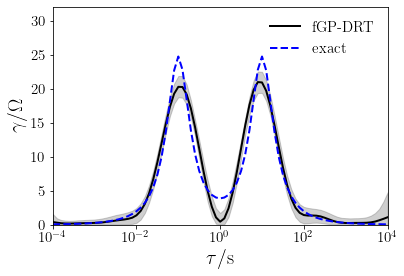

In [93]:
gamma_avg = np.average(samples_gamma,axis=1)
gamma_std = np.std(samples_gamma,axis=1)
gamma_median = np.nanmedian(samples_gamma,axis=1)
gamma_percentile_0dot1 = np.percentile(samples_gamma, 1, axis=1)
gamma_percentile_0dot5 = np.percentile(samples_gamma, 50, axis=1)
gamma_percentile_0dot9 = np.percentile(samples_gamma, 99, axis=1)

# plot the DRT and its confidence region
plt.semilogx(tau_vec, gamma_median, linewidth=2, color='black', label='fGP-DRT')
plt.fill_between(tau_vec, gamma_percentile_0dot1, gamma_percentile_0dot9, 
                 color='0.25', alpha=0.25)
plt.semilogx(tau_vec, gamma_fct, '--', linewidth=2, color='blue', label='exact')

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4, 1E4, 0 ,32])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/{\rm s}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
fig.set_size_inches(6.472, 4)
plt.show()

### 2.9)  Plot of the constrained impedance

In [94]:
Z_re_im_avg = np.average(samples_Z_re_im,axis=1)
Z_re_im_std = np.std(samples_Z_re_im,axis=1)
Z_re_im_median = np.nanmedian(samples_Z_re_im,axis=1)
Z_re_im_percentile_0dot1 = np.percentile(samples_Z_re_im, 1, axis=1)
Z_re_im_percentile_0dot5 = np.percentile(samples_Z_re_im, 50, axis=1)
Z_re_im_percentile_0dot9 = np.percentile(samples_Z_re_im, 99, axis=1)

Z_re_median = Z_re_im_median[:N_freqs]
Z_im_median = Z_re_im_median[N_freqs:]

Z_re_percentile_0dot1 = Z_re_im_percentile_0dot1[:N_freqs]
Z_re_percentile_0dot9 = Z_re_im_percentile_0dot9[:N_freqs]
Z_im_percentile_0dot1 = Z_re_im_percentile_0dot1[N_freqs:]
Z_im_percentile_0dot9 = Z_re_im_percentile_0dot9[N_freqs:]

###  Comparison of the impedance from the constrained fGP-DRT against the exact one

### Figure 8 (e)

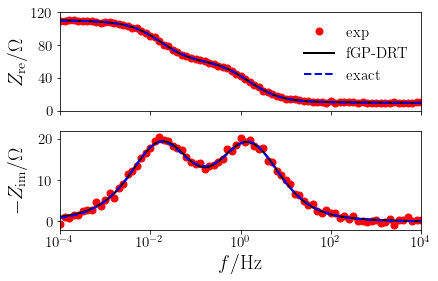

In [95]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.semilogx(freq_vec, Z_exp.real, 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, Z_re_median, linewidth=2, color='black', label='fGP-DRT')
ax1.fill_between(freq_vec, Z_re_percentile_0dot1, Z_re_percentile_0dot9, 
                 color='0.25', alpha=0.25)
ax1.semilogx(freq_vec, Z_exact.real, '--', linewidth=2, color='blue', label='exact')
ax1.set_ylabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
ax1.axis([1E-4, 1E4, 5, 120])
ax1.legend(frameon=False, fontsize = 15)
ax1.set_yticks(np.arange(0, 130, step=40)) 

ax2.semilogx(freq_vec, -Z_exp.imag, 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec, -Z_im_median, linewidth=2, color='black', label='fGP-DRT')
ax2.fill_between(freq_vec, -Z_im_percentile_0dot1, -Z_im_percentile_0dot9, 
                 color='0.25', alpha=0.25)
ax2.semilogx(freq_vec, -Z_exact.imag, '--', linewidth=2, color='blue', label='exact')
ax2.set_ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
ax2.axis([1E-4, 1E4, -2, 22])


plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.set_size_inches(6.472, 4)

fig.align_ylabels()
#
plt.show()